# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm
import uuid

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


# Hyperparams

In [2]:
# root = os.getcwd()
# dataset =  os.path.join(root, 'dataset', 'amazon_full')
# #yelp polarity has 2 labels, 
# #yelp dataset has 5 labels, they have the same text content
# train_datapath = os.path.join(dataset, 'train.csv') 
# test_datapath = os.path.join(dataset, 'test.csv') 

# processed_train_dataset = os.path.join(dataset, 'processed_train_datset.pickle')
# processed_test_dataset = os.path.join(dataset, 'processed_test_dataset.pickle')
# vocab_save_path = os.path.join(dataset, 'vocab.pickle')

ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_full' )

CLEANED_TRAIN_DATAPATH = os.path.join(DATASET_PATH, 'cleaned_train_5%.csv')
CLEANED_TEST_DATAPATH = os.path.join(DATASET_PATH, 'cleaned_test_1%.csv')

# model_save_root = os.path.join(root, 'output', 'transformer')

OUTPUT_PATH = os.path.join(ROOT, 'output', 'transformer')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)

id = str(uuid.uuid4()).split('-')[0]
EXP_NAME = f'baseline_{id}'

BATCH_SIZE = 64
MAX_SEQUENCE_LENGTH = 512

print(EXP_NAME)

baseline_cdbfa0b0


# Cleaning

In [3]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #after cleaning, there's a letter n that occur most frequently
    #this don't make sense so remove a standalone letter n
    text = ' '.join(t for t in text.split() if t != '' and t != 'n')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)


'test string special characters punctuations _'

In [4]:
train_df = pd.read_csv(CLEANED_TRAIN_DATAPATH)
NUM_CLASSES = len(train_df['review'].unique())
test_df = pd.read_csv(CLEANED_TEST_DATAPATH)
print(NUM_CLASSES)

5


# Prepare data

In [5]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 800):
    X_tokens = []
    X_lengths = []
    max_len = 0
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        max_len = max(max_len, len(tokens))
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    print('max len = ', max_len)
    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 2, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor(labels)
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id


In [6]:
# all_df = pd.concat([train_df, test_df])
# all_df['text'] = all_df['text'].apply(lambda s: clean_text(s))

In [7]:
X_array = train_df['text'].values
y_array = train_df['review'].values

(train_tokens, train_ids, train_y, train_lengths) ,vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', train_ids.shape )
print('y values = ', set(train_y.tolist()) )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

#Test
test_X_array = test_df['text'].values
test_y_array = test_df['review'].values

(test_tokens, test_ids, test_y, test_lengths) ,_, _ = build_train_test_data(test_X_array, test_y_array)

test_ids = pad_sequence(test_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', test_ids.shape )
print('y values = ', set(test_y.tolist()) )
print('y shape = ', test_y.shape )
print('lengths shape = ', test_lengths.shape)

100%|██████████| 149992/149992 [00:06<00:00, 23286.51it/s]


max len =  405
vocab len =  75299


100%|██████████| 149992/149992 [00:04<00:00, 34668.18it/s]


ids shape =  torch.Size([149992, 405])
y values =  {0, 1, 2, 3, 4}
y shape =  torch.Size([149992])
lengths shape =  torch.Size([149992])


100%|██████████| 6499/6499 [00:00<00:00, 21947.44it/s]


max len =  250
vocab len =  13715


100%|██████████| 6499/6499 [00:00<00:00, 22108.68it/s]

ids shape =  torch.Size([6499, 250])
y values =  {0, 1, 2, 3, 4}
y shape =  torch.Size([6499])
lengths shape =  torch.Size([6499])


In [8]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=1
tokens=['i', 'was', 'terribly', 'disappointed', 'to', 'find', 'that', 'the', 'verb', 'drills', 'on', 'these', 'cds', 'do', 'not', 'include', 'the', 'informal', '2d', 'person', 'plural', 'vosotros', ',', 'as', 'used', 'in', 'spain', 'and', ',', 'just', 'as', 'importantly', ',', 'in', 'much', 'classic', 'spanish', 'literature', '.', 'i', 'see', 'no', 'point', 'in', 'learning', 'some', 'forms', 'of', 'each', 'tense', 'and', 'mood', 'of', 'verbs', 'and', 'not', 'all', 'of', 'them', '.', 'on', 'the', 'other', 'hand', ',', 'it', 'is', 'true', 'that', 'the', 'vosotros', 'form', 'is', 'almost', 'never', 'used', 'in', 'the', 'americas', ',', 'so', 'i', 'suppose', 'this', 'is', 'helpful', 'material', 'for', 'those', 'who', 'want', 'to', 'learn', 'spanish', 'only', 'for', 'use', 'in', ',', 'say', ',', 'mexico', 'or', 'guatemala', '.', 'but', 'why', 'do', 'that', '?', 'if', 'you', 'decide', 'you', 'want', 'to', 'anyway', ',', 'this', 'is', 'pure', 'drill', 'material', ',', 'and', 'if', 'yo

# Model

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, num_hiddens: int, dropout:float = 0, max_len: int = 5000):
        super().__init__()
        assert num_hiddens % 2 == 0, f'num hiddens ({num_hiddens}),has to be even'

        self.dropout = nn.Dropout(dropout)

        self.P = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len).float().unsqueeze(1)
        #N = 10000 as defined in the Attention is All You Need paper
        denom = torch.pow(10000, torch.arange(0, num_hiddens,2).float()/num_hiddens)
        x = x/denom
        self.P[:,:,0::2] = torch.sin(x)
        self.P[:,:,1::2] = torch.cos(x)

        # self.P = self.P.to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # assert x.device == self.P.device, 'in positional encoding, X should have the same device with P'
        batch_size, length, num_hiddens = x.shape
        x = x + self.P[:,:length,:].to(x.device)
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_class, 
    num_heads, dim_fc, num_tokens, 
    dropout = 0.2, num_encoder_layers = 2, batch_first = True):

        '''
        @params:
            input_size: input features or embedding size
            num_heads: number of multi attentino heads 
            dim_fc:  dimension of feedforward layer
            dropout: drop out rate
            num_tokens: number of tokens in vocabulary (some call vocab_size)
        '''
        super().__init__()

        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.encoder_layers = nn.TransformerEncoderLayer(
            d_model = input_size,
            nhead = num_heads,
            dim_feedforward= dim_fc,
            dropout = dropout,
            batch_first=batch_first,
        )

        self.encoder = nn.TransformerEncoder(encoder_layer=self.encoder_layers, num_layers = num_encoder_layers)
        self.embedding = nn.Embedding(num_tokens, input_size)
        self.input_size = input_size 

        self.fc = nn.Linear(input_size, num_class) 

        self._init_weights()
    
    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def forward(self, src, mask = None):
        batch_size, input_len = src.shape
        
        src = self.embedding(src)
        src = src * math.sqrt(self.input_size)
        src = self.pos_encoder(src)

        if mask == None:
            mask = nn.Transformer.generate_square_subsequent_mask(input_len).to(src.device)

        transformer_output = self.encoder(src, mask)

        # print('transformer output shape = ', transformer_output.shape)
        output = self.fc(transformer_output[:,-1]) 
        # print('fc output shape = ', output.shape)
        return output

In [10]:
# input_size = 100 
# num_class = 2
# num_heads = 5
# fc_hidden_size = 5
# num_tokens = 1000
    
# clf = TransformerClassifier(input_size, num_class, num_heads, fc_hidden_size, num_tokens)
# clf.to(DEVICE)
# # clf.convert_to_device(DEVICE)
# X = torch.randint(0,1000,(10,5)).to(DEVICE)

# y = clf(X, None)

# Dataset

In [11]:
class YelpReview(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]


In [12]:
train_dataset = YelpReview(train_ids, train_y, train_lengths)
test_dataset = YelpReview(test_ids, test_y, test_lengths)

print(train_dataset)
print(vocab)
print(len(vocab))

NUM_CLASSES = len(set(train_dataset.labels.tolist()))
print('num classes = ', NUM_CLASSES)

# print(train_dataset)

# Save the YelpDataset

# with open(processed_train_dataset, 'wb') as file:
#     pickle.dump(train_dataset, file)

# with open(processed_test_dataset, 'wb') as file:
#     pickle.dump(test_dataset, file)

# with open(vocab_save_path, 'wb') as file:
#     pickle.dump(vocab, file)


Vocab()
75299
num classes =  5


In [13]:
# Load dataset
# with open(processed_train_dataset, 'rb') as file:
#     train_dataset = pickle.load(file)

# with open(processed_test_dataset, 'rb') as file:
#     test_dataset = pickle.load(file)

# with open(vocab_save_path, 'rb') as file:
#     vocab = pickle.load(file)

# print(train_dataset)
# print(vocab)
# print(len(vocab))

# NUM_CLASSES = len(set(train_dataset.labels.tolist()))
# print('num classes = ', NUM_CLASSES)

In [14]:
# test model running on dataloader

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
test_val_len = (len(train_dataset) - train_len)
train_dataset, val_dataset = random_split(train_dataset,[train_len, test_val_len])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))
print('test dataset len = ', len(test_dataset))
print('test dataloader len = ', len(test_dataloader))

(sample_ids, sample_y, sample_lengths) = next(iter(train_dataloader)) 
print('id shape = ', sample_ids.shape)
print('label shape = ', sample_y.shape)
print('lengths shape = ', sample_lengths.shape)


num class =  5
train dataset len =  119993
train dataloader len =  1875
val dataset len =  29999
val dataloader len =  469
test dataset len =  6499
test dataloader len =  102
id shape =  torch.Size([64, 405])
label shape =  torch.Size([64])
lengths shape =  torch.Size([64])


# Tune function

In [15]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.to(device)
    model.train()
    epoch_losses = []
    epoch_accs = []

    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        label = label.to(device)
        length = length
        # prediction = model(ids, length)
        prediction = model(ids)

        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

def pickle_dump(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
        
def pickle_load(path):
    with open(path, 'wb') as file:
        obj = pickle.load(file)
    return obj

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        # prediction = model(ids, length)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def tune(model,train_dataloader, val_dataloader, test_dataloader,  
         optimizer, criterion, device, epochs = 10, label = EXP_NAME, history = None):
    print(f"The model has {model.count_parameters()} trainable parameters")

    criterion = criterion.to(device)
    best_score = -float("inf")

    SAVE_PATH = os.path.join(OUTPUT_PATH, label)
    PLOT_PATH = os.path.join(SAVE_PATH, 'plot.png')

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    if history == None:
        history = collections.defaultdict(list)

    model.to(device)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        history["test_losses"].append(test_loss)
        history["test_accs"].append(test_acc)

        if test_acc > best_score:
            best_score = test_loss
            torch.save(model, os.path.join(SAVE_PATH, "transformers.checkpont.torch"))

        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

        plot(history, save_path = os.path.join(SAVE_PATH, 'plot.png'))

        pickle_dump(history, os.path.join(SAVE_PATH, 'history.pickle'))

    
    plot(history, save_path = os.path.join(SAVE_PATH, 'plot.png'), show = True)
    return history

def plot(history, save_path = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))
    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    sns.lineplot(y = history["test_accs"],   label ='test accuracy',    x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_losses"],   label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.clf()

# Pretrained embedding

In [16]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

# Run transformers

### Dropout Rate

output dim =  5
The model has 24602441 trainable parameters


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 56.14it/s]


epoch: 0
train_loss: 1.345, train_acc: 0.410
val_loss: 1.343, valid_acc: 0.462
test_loss: 2.693, test_acc: 0.199


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 55.65it/s]


epoch: 1
train_loss: 1.222, train_acc: 0.468
val_loss: 1.401, valid_acc: 0.471
test_loss: 2.984, test_acc: 0.200


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 54.69it/s]


epoch: 2
train_loss: 1.179, train_acc: 0.491
val_loss: 1.335, valid_acc: 0.480
test_loss: 2.789, test_acc: 0.196


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 55.64it/s]


epoch: 3
train_loss: 1.147, train_acc: 0.507
val_loss: 1.396, valid_acc: 0.474
test_loss: 2.989, test_acc: 0.189


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 55.95it/s]


epoch: 4
train_loss: 1.111, train_acc: 0.526
val_loss: 1.415, valid_acc: 0.478
test_loss: 2.933, test_acc: 0.198


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 54.29it/s]


epoch: 5
train_loss: 1.080, train_acc: 0.541
val_loss: 1.479, valid_acc: 0.470
test_loss: 3.022, test_acc: 0.196


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 54.21it/s]


epoch: 6
train_loss: 1.050, train_acc: 0.559
val_loss: 1.587, valid_acc: 0.471
test_loss: 3.166, test_acc: 0.201


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 56.15it/s]


epoch: 7
train_loss: 1.019, train_acc: 0.571
val_loss: 1.657, valid_acc: 0.466
test_loss: 3.228, test_acc: 0.192


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 55.80it/s]


epoch: 8
train_loss: 0.997, train_acc: 0.583
val_loss: 1.693, valid_acc: 0.464
test_loss: 3.373, test_acc: 0.200


evaluating...: 100%|██████████| 102/102 [00:01<00:00, 55.89it/s]


epoch: 9
train_loss: 0.972, train_acc: 0.597
val_loss: 1.732, valid_acc: 0.464
test_loss: 3.123, test_acc: 0.201


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

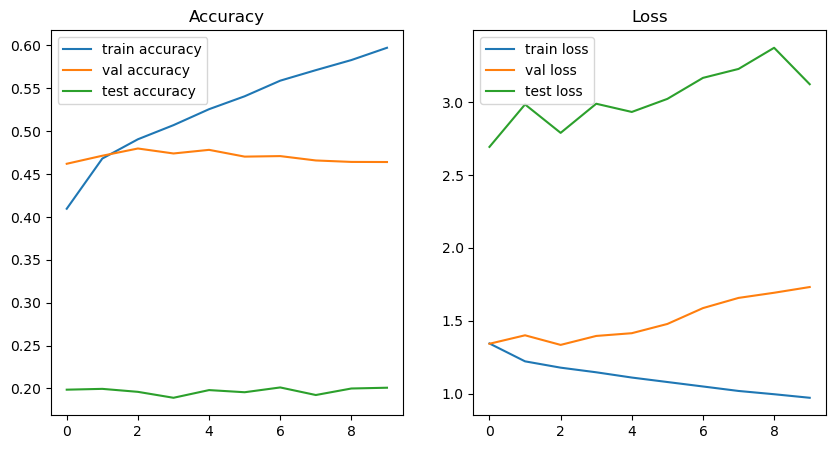

<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [17]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5
epochs = 10

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 512,
    num_tokens = vocab_size,
    dropout = dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = tune(model,  train_dataloader, val_dataloader, test_dataloader, 
               optimizer, criterion, epochs = epochs, device = DEVICE)

plot(history)

# Notes

test accuracy not improving. Perhaps the train vocab and test vocab is too different. Try merging train and test tokens. See what happens.